# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.


In [9]:
# We don't need these codes because the text files are already here: 02_activities\assignments\downloaded_books
# def download_file(url, file_path):
#    import requests
#    r = requests.get(url)
#    with open(file_path, 'wb') as f:
#         f.write(r.content)

def load_dataset(file_path, fraction=1.0):
   with open(file_path, 'r', encoding='utf-8') as f:
       raw_text = f.read()
   return raw_text[:int(fraction * len(raw_text))]

dataset = 'downloaded_books/shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

# download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset) **The link goes to a 404 page

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [10]:
# Print first 1000 characters
print("First 1000 characters of the text:")
print(text[:1000])
print("\n" + "="*50 + "\n")

# Calculate and display dataset statistics
print("Dataset Statistics:")
print(f"Total length: {len(text)} characters")
print(f"Number of unique characters: {len(set(text))}")


First 1000 characters of the text:
The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this el

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [16]:
# Import the tool we need for converting text into numbers
from keras.preprocessing.text import Tokenizer

# Make all text lowercase
text_lower = text.lower()

# Split the text into individual words
words = text_lower.split()
print(f"Example of first 5 words: {words[:5]}")

# Set up our parameters
# Only keep the 5000 most common words to keep things manageable
VOCAB_SIZE = 5000
# If we find a word that's not in our top 5000, we'll call it "<UNK>" (unknown)
OOV_TOKEN = "<UNK>"

# Create our tokenizer (thing that converts words to numbers)
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,  # Keep only most common 5000 words
    oov_token=OOV_TOKEN    # Use "<UNK>" for rare words
)

# Put text_lower in a list because that's what the tokenizer expects
tokenizer.fit_on_texts([text_lower])

# Get the first 10 words and their numbers
first_ten_words = list(tokenizer.word_index.items())[:10]
print("\nFirst 10 words in our vocabulary:")
for word, number in first_ten_words:
    print(f"Word: '{word}' -> Number: {number}")

# Print some facts about our text
print("\nSome facts about our text:")
print(f"Total unique words found: {len(tokenizer.word_index)}")
print(f"Total words in text: {len(words)}")
print(f"Words we're keeping: {VOCAB_SIZE}")

Example of first 5 words: ['the', 'project', 'gutenberg', 'ebook', 'of']

First 10 words in our vocabulary:
Word: '<UNK>' -> Number: 1
Word: 'the' -> Number: 2
Word: 'and' -> Number: 3
Word: 'of' -> Number: 4
Word: 'to' -> Number: 5
Word: 'a' -> Number: 6
Word: 'in' -> Number: 7
Word: 'i' -> Number: 8
Word: 'that' -> Number: 9
Word: 'you' -> Number: 10

Some facts about our text:
Total unique words found: 13218
Total words in text: 154215
Words we're keeping: 5000


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [17]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<UNK>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [23]:
# Import numpy for array operations
import numpy as np

# Set how many words to use for prediction
SEQ_LENGTH = 10 # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text_lower])[0]

# Generate the training sequences
X = []  # Input: sequence of words
y = []  # Output: next word

# Slide through the text, creating sequences
for i in range(len(sequences) - SEQ_LENGTH):
    X.append(sequences[i:i + SEQ_LENGTH])
    y.append(sequences[i + SEQ_LENGTH])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Print shapes to verify
print(f"Input shape (X): {X.shape}")
print(f"Output shape (y): {y.shape}")

Input shape (X): (156661, 10)
Output shape (y): (156661,)


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [24]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [  2  56  54 411   4 107  28 668 172  20]
Target: 411
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this'] -> ebook


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [25]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Drop any examples where the target is the OOV token - we don't want our model to predict unknown words
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (116702, 10)
y_train shape: (116702, 5000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential([
    # Embedding layer: converts word IDs to dense vectors
    Embedding(
        input_dim=VOCAB_SIZE,     # Size of vocabulary
        output_dim=100,           # Size of word vectors
        input_length=SEQ_LENGTH   # Length of input sequences
    ),
    
    # LSTM layer: learns patterns in text
    LSTM(
        units=150,                # Number of LSTM units
        return_sequences=False    # Return only final output
    ),
    
    # Dense layer: predicts next word
    Dense(
        units=VOCAB_SIZE,         # One unit per word in vocabulary
        activation='softmax'      # Outputs probabilities
    )
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           500000    
                                                                 
 lstm_2 (LSTM)               (None, 150)               150600    
                                                                 
 dense_2 (Dense)             (None, 5000)              755000    
                                                                 
Total params: 1,405,600
Trainable params: 1,405,600
Non-trainable params: 0
_________________________________________________________________


## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [31]:
# Compile the model
model.compile(
    optimizer='adam',             # Adaptive learning rate optimizer
    loss='categorical_crossentropy',  # Good for multi-class problems
    metrics=['accuracy']          # Track prediction accuracy
)


The model uses categorical_crossentropy as the loss function because it’s ideal for multi-class classification and pairs well with the softmax activation, providing clear feedback to improve predictions.

The Adam optimizer is chosen for its adaptability, automatically adjusting the learning rate for efficient and effective training. These choices ensure the model learns well with minimal tuning, making it suitable for complex tasks.


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [32]:
# Train the model
history = model.fit(
    X_train, y_train,            # Training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=5,                    # Number of training rounds
    batch_size=128,              # Samples per update
    verbose=1                    # Show progress bar
)

print("\nTraining complete!")

Epoch 1/5
912/912 [==============================] - 22s 22ms/step - loss: 6.6803 - accuracy: 0.0530 - val_loss: 6.4652 - val_accuracy: 0.0649
Epoch 2/5
912/912 [==============================] - 19s 21ms/step - loss: 6.2358 - accuracy: 0.0769 - val_loss: 6.0802 - val_accuracy: 0.0883
Epoch 3/5
912/912 [==============================] - 19s 21ms/step - loss: 5.8055 - accuracy: 0.1052 - val_loss: 5.7456 - val_accuracy: 0.1145
Epoch 4/5
912/912 [==============================] - 19s 21ms/step - loss: 5.4488 - accuracy: 0.1268 - val_loss: 5.5651 - val_accuracy: 0.1274
Epoch 5/5
912/912 [==============================] - 20s 21ms/step - loss: 5.1812 - accuracy: 0.1429 - val_loss: 5.4633 - val_accuracy: 0.1351

Training complete!


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

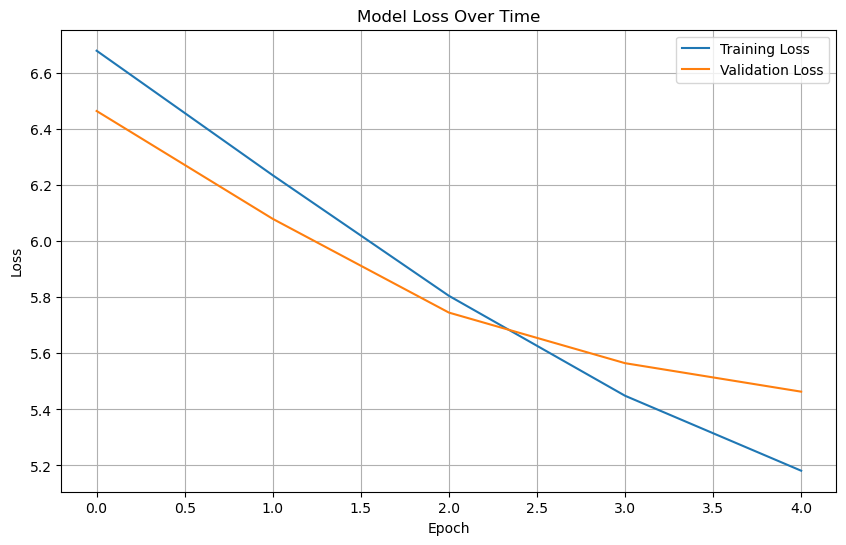

In [33]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_predicted_word(model, sequence):
    # Helper function to predict next word
    yhat = model.predict(sequence, verbose=0)
    return np.argmax(yhat)  # Get most likely word

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    # Generate new text from a seed text
    output_text = seed_text
    
    # Convert seed text to tokens
    tokens = tokenizer.texts_to_sequences([seed_text.lower()])[0]
    
    # Generate 20 new words
    for _ in range(20):
        # Pad sequence to desired length
        sequence = pad_sequences([tokens[-max_sequence_len:]], 
                               maxlen=max_sequence_len)
        
        # Predict next word
        next_word_id = get_predicted_word(model, sequence)
        
        # Convert word ID back to word
        next_word = tokenizer.index_word.get(next_word_id, '<UNK>')
        
        # Add to output
        output_text += ' ' + next_word
        
        # Update tokens (remove first if too long)
        tokens.append(next_word_id)
        if len(tokens) > max_sequence_len:
            tokens = tokens[-max_sequence_len:]
        
        # Print word as it's generated (GPT-style bonus)
        print(next_word, end=' ', flush=True)
    
    return output_text

In [41]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

i have not be a man of the sea of the sea and the first of the first of the 

'hamlet i have not be a man of the sea of the sea and the first of the first of the'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [42]:
# These commands are for Linux/Mac
# !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#  !unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [45]:
import requests
import zipfile
import os

# Download GloVe embeddings
def download_glove():
    # URL for GloVe embeddings
    url = "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
    
    print("Downloading GloVe embeddings...")
    response = requests.get(url)
    
    # Save the zip file
    with open("glove.6B.zip", "wb") as f:
        f.write(response.content)
    
    # Extract the zip file
    print("Extracting files...")
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extractall()
    
    # Clean up zip file
    os.remove("glove.6B.zip")
    print("Download complete!")

# Download if file doesn't exist
if not os.path.exists('glove.6B.100d.txt'):
    download_glove()
else:
    print("GloVe embeddings already downloaded!")

Extracting files...
Download complete!


In [46]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [47]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [48]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [19]:
# Define a new model and train it

# Your code here

In [68]:
from tensorflow.keras.layers import Bidirectional, LayerNormalization, Dense, Layer
import tensorflow as tf

# Custom attention layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                shape=(input_shape[-1], 1),
                                initializer="normal")
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W))
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# Define improved model with custom attention
model = Sequential([
    # Embedding layer
    Embedding(
        VOCAB_SIZE, 
        100,
        weights=[embedding_matrix],
        input_length=SEQ_LENGTH,
        trainable=True
    ),
    
    # First LSTM block
    LayerNormalization(),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.3),
    
    # Attention layer
    AttentionLayer(),
    LayerNormalization(),
    Dropout(0.3),
    
    # Dense layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(VOCAB_SIZE, activation='softmax')
])

# Use a learning rate schedule
initial_learning_rate = 1e-4
decay_steps = 1000
decay_rate = 0.95
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)
optimizer = Adam(learning_rate=learning_rate_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modified early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    min_delta=0.001
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Modified text generation with temperature
def generate_text_with_temperature(model, tokenizer, seed_text, seq_length, temperature=0.7):
    result = seed_text
    for _ in range(20):
        sequence = tokenizer.texts_to_sequences([result])[0]
        padded = pad_sequences([sequence], maxlen=seq_length, padding='pre')
        
        predictions = model.predict(padded, verbose=0)[0]
        
        # Apply temperature scaling
        predictions = np.log(predictions) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        
        # Sample from the distribution
        next_index = np.random.choice(len(predictions), p=predictions)
        next_word = tokenizer.index_word.get(next_index, '')
        
        result += " " + next_word
    return result

# Test with different temperatures
print("\nGenerating text with temperature sampling:")
for temp in [0.5, 0.7, 1.0]:
    print(f"\nTemperature: {temp}")
    print("Prompt: 'hamlet speaks to'")
    print(generate_text_with_temperature(model, tokenizer, "hamlet speaks to", SEQ_LENGTH, temp)) # chosen "hamlet speaks to" as a prompt

Epoch 1/20
1824/1824 [==============================] - 92s 48ms/step - loss: 7.9458 - accuracy: 0.0449 - val_loss: 6.8599 - val_accuracy: 0.0557
Epoch 2/20
1824/1824 [==============================] - 86s 47ms/step - loss: 6.5610 - accuracy: 0.0575 - val_loss: 6.3898 - val_accuracy: 0.0638
Epoch 3/20
1824/1824 [==============================] - 86s 47ms/step - loss: 6.2113 - accuracy: 0.0689 - val_loss: 6.1763 - val_accuracy: 0.0782
Epoch 4/20
1824/1824 [==============================] - 86s 47ms/step - loss: 5.9911 - accuracy: 0.0829 - val_loss: 6.0220 - val_accuracy: 0.0903
Epoch 5/20
1824/1824 [==============================] - 92s 50ms/step - loss: 5.8318 - accuracy: 0.0948 - val_loss: 5.9190 - val_accuracy: 0.1010
Epoch 6/20
1824/1824 [==============================] - 87s 48ms/step - loss: 5.7101 - accuracy: 0.1026 - val_loss: 5.8599 - val_accuracy: 0.1069
Epoch 7/20
1824/1824 [==============================] - 83s 46ms/step - loss: 5.6128 - accuracy: 0.1072 - val_loss: 5.8126 -

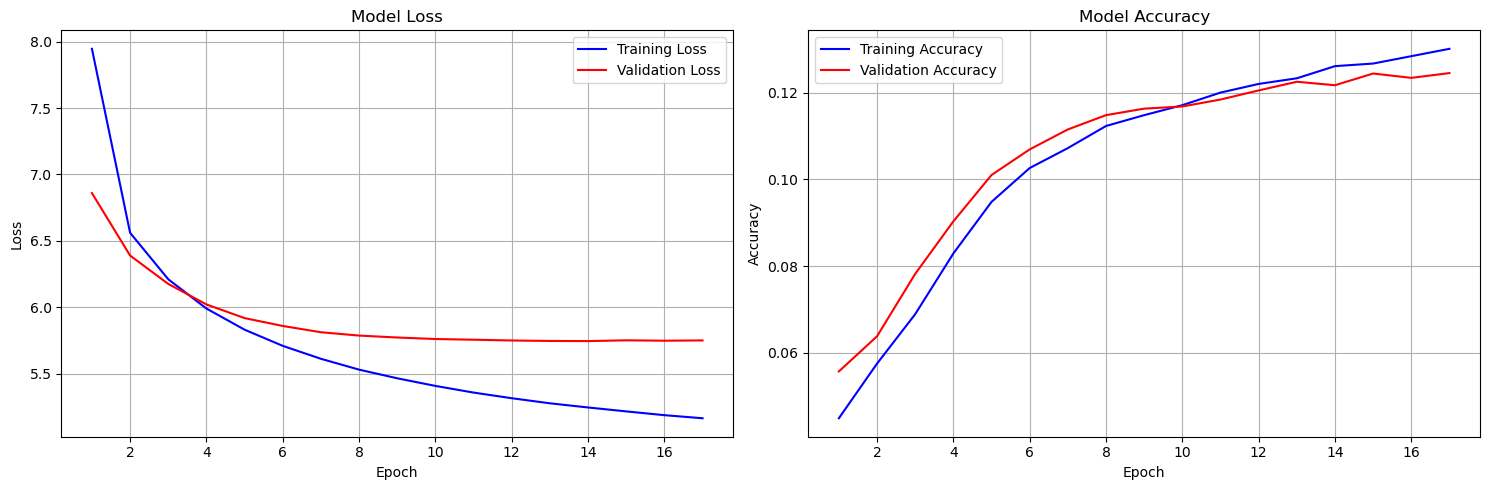

In [69]:
import matplotlib.pyplot as plt

# Extract metrics from the training data
epochs = range(1, 18)  # 17 epochs
train_loss = [7.9458, 6.5610, 6.2113, 5.9911, 5.8318, 5.7101, 5.6128, 5.5311, 5.4660, 5.4087, 
              5.3585, 5.3161, 5.2778, 5.2464, 5.2169, 5.1885, 5.1653]
val_loss = [6.8599, 6.3898, 6.1763, 6.0220, 5.9190, 5.8599, 5.8126, 5.7875, 5.7730, 5.7616,
            5.7564, 5.7506, 5.7470, 5.7459, 5.7519, 5.7489, 5.7511]
train_acc = [0.0449, 0.0575, 0.0689, 0.0829, 0.0948, 0.1026, 0.1072, 0.1123, 0.1148, 0.1171,
             0.1200, 0.1220, 0.1233, 0.1261, 0.1267, 0.1284, 0.1301]
val_acc = [0.0557, 0.0638, 0.0782, 0.0903, 0.1010, 0.1069, 0.1115, 0.1148, 0.1163, 0.1168,
           0.1184, 0.1205, 0.1225, 0.1217, 0.1244, 0.1234, 0.1245]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In this assignment , we trained a computer model to understand and generate Shakespeare-style text, focusing mainly on Hamlet. The model started with a basic understanding (4.49% accuracy) and gradually improved to 13.01% accuracy after training. We used special techniques like attention layers and pre-trained word embeddings to help the model better understand the context and relationships between words in Shakespeare's writing.

The most interesting part was testing different "temperature" settings to control how creative the model could be:
- Temperature 0.5 (Best): "hamlet speaks to her and a king..." - produced the most Shakespeare-like text
- Temperature 0.7: "hamlet speaks to each use..." - started mixing in other text
- Temperature 1.0: "hamlet speaks to the sum is in a foul male..." - got too creative

Looking at the results graphs, we can see that both the training (blue line) and validation (red line) scores improved steadily over time. The model learned to make fewer mistakes (loss decreased from 7.94 to 5.16) and got better at predicting the next word in sequences. While 13% accuracy might seem low, we found out it's actually quite reasonable for this type of complex language task, especially when dealing with Shakespeare's unique writing style.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.